# Analyzing Susceptibility Scores
Given a CSV with the columns:

```q_id,	query_form,	entity,	contexts,	susceptibility_score```

Analyze the results for patterns and correlations

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import os
import sys
import math
import random
from itertools import product
from tqdm import tqdm
import yaml

import pandas as pd
import seaborn as sns

# from transformers import GPTNeoXForCausalLM, AutoTokenizer
import torch
from typing import List
from matplotlib import pyplot as plt
import numpy as np
import wandb

import statsmodels.api as sm

# from measuring.estimate_probs import (
#     estimate_prob_y_given_context_and_entity,
#     estimate_prob_x_given_e,
#     estimate_prob_next_word_given_x_and_entity,
#     estimate_cmi,
#     score_model_for_next_word_prob,
#     create_position_ids_from_input_ids,
#     sharded_score_model,
#     estimate_entity_score,
#     kl_div,
#     difference,
#     difference_p_good_only,
#     difference_abs_val,
# )
from preprocessing.datasets import CountryCapital, FriendEnemy

### Preamble

In [3]:
##################
### Parameters ###
##################

# Data parameters
SEED = 0
# DATASET_NAME = "CountryCapital"
# DATASET_KWARGS_IDENTIFIABLE = dict(
#     max_contexts=450,
#     max_entities=90,
#     cap_per_type=True,
#     raw_country_capitals_path="data/CountryCapital/real-fake-historical-fictional-famousfictional-country-capital.csv",
# )
DATASET_NAME = "FriendEnemy"
# DATASET_KWARGS_IDENTIFIABLE = dict(
#     max_contexts=15,
#     max_entities=5,
#     cap_per_type=False,
#     raw_data_path="data/FriendEnemy/raw-friend-enemy.csv",
# )
DATASET_KWARGS_IDENTIFIABLE = dict(
    max_contexts=657,
    max_entities=73,
    cap_per_type=False,
    raw_data_path="data/FriendEnemy/raw-friend-enemy.csv",
)
LOG_DATASETS = True

# Model parameters
# MODEL_ID = "EleutherAI/pythia-70m-deduped"
# LOAD_IN_8BIT = False
MODEL_ID = "EleutherAI/pythia-6.9b-deduped"
LOAD_IN_8BIT = True
BATCH_SZ = 16

# Evaluation switches
COMPUTE_CMI = True
COMPUTE_KL = True
COMPUTE_GOOD_BAD = True
COMPUTE_GOOD_BAD_ABS = True
COMPUTE_GOOD_BAD_P_GOOD_ONLY = True

# wandb stuff
PROJECT_NAME = "context-vs-bias"
GROUP_NAME = None
TAGS = ["friend-enemy", "analysis"]

In [4]:
# Paths
# Construct dataset and data ids
# dataset = getattr(sys.modules[__name__], DATASET_NAME)(**DATASET_KWARGS_IDENTIFIABLE)
data_id = f"{DATASET_NAME}"
data_id += (
    f"-mc{DATASET_KWARGS_IDENTIFIABLE['max_contexts']}"
    if "max_contexts" in DATASET_KWARGS_IDENTIFIABLE
    and DATASET_KWARGS_IDENTIFIABLE["max_contexts"] is not None
    else ""
)
data_id += (
    f"-me{DATASET_KWARGS_IDENTIFIABLE['max_entities']}"
    if "max_entities" in DATASET_KWARGS_IDENTIFIABLE
    and DATASET_KWARGS_IDENTIFIABLE["max_entities"] is not None
    else ""
)
data_id += (
    "-cappertype"
    if "cap_per_type" in DATASET_KWARGS_IDENTIFIABLE
    and DATASET_KWARGS_IDENTIFIABLE["cap_per_type"]
    else ""
)
data_id += (
    "-ablate"
    if "ablate_out_relevant_contexts" in DATASET_KWARGS_IDENTIFIABLE
    and DATASET_KWARGS_IDENTIFIABLE["ablate_out_relevant_contexts"]
    else ""
)

data_dir = os.path.join("data", DATASET_NAME, data_id, f"{SEED}")
input_dir = os.path.join(data_dir, "inputs")
entities_path = os.path.join(input_dir, "entities.json")
contexts_path = os.path.join(input_dir, "contexts.json")
queries_path = os.path.join(input_dir, "queries.json")
val_data_path = os.path.join(input_dir, "val.csv")
DATASET_KWARGS_IDENTIFIABLE = {
    **DATASET_KWARGS_IDENTIFIABLE,
    **dict(
        entities_path=entities_path,
        contexts_path=contexts_path,
        queries_path=queries_path,
    ),
}

# Construct model id
model_id = f"{MODEL_ID}"
model_id += "-8bit" if LOAD_IN_8BIT else ""
model_dir = os.path.join(data_dir, "models", model_id)

# Results path
results_dir = os.path.join(model_dir, "results")
val_results_path = os.path.join(results_dir, "val.csv")

print(f"Data dir: {data_dir}")
print(f"Model dir: {model_dir}")

Data dir: data/FriendEnemy/FriendEnemy-mc657-me73/0
Model dir: data/FriendEnemy/FriendEnemy-mc657-me73/0/models/EleutherAI/pythia-6.9b-deduped-8bit


In [5]:
# Analysis dir
analysis_dir = os.path.join(data_dir, "analysis")
print(f"Analysis dir: {analysis_dir}")

Analysis dir: data/FriendEnemy/FriendEnemy-mc657-me73/0/analysis


In [6]:
os.makedirs(input_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
os.makedirs(analysis_dir, exist_ok=True)
dataset = getattr(sys.modules[__name__], DATASET_NAME)(**DATASET_KWARGS_IDENTIFIABLE)

In [7]:
# Set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [8]:
# GPU stuff
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
# wandb stuff
os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join(os.getcwd(), "analysis.ipynb")

params_to_log = {k: v for k, v in locals().items() if k.isupper()}

run = wandb.init(
    project=PROJECT_NAME,
    group=GROUP_NAME,
    config=params_to_log,
    tags=TAGS,
    mode="online",
)
print(dict(wandb.config))

wandb: Currently logged in as: kdu (ethz-rycolab). Use `wandb login --relogin` to force relogin
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smalle

{'SEED': 0, 'DATASET_NAME': 'FriendEnemy', 'DATASET_KWARGS_IDENTIFIABLE': {'max_contexts': 657, 'max_entities': 73, 'cap_per_type': False, 'raw_data_path': 'data/FriendEnemy/raw-friend-enemy.csv', 'entities_path': 'data/FriendEnemy/FriendEnemy-mc657-me73/0/inputs/entities.json', 'contexts_path': 'data/FriendEnemy/FriendEnemy-mc657-me73/0/inputs/contexts.json', 'queries_path': 'data/FriendEnemy/FriendEnemy-mc657-me73/0/inputs/queries.json'}, 'LOG_DATASETS': True, 'MODEL_ID': 'EleutherAI/pythia-6.9b-deduped', 'LOAD_IN_8BIT': True, 'BATCH_SZ': 16, 'COMPUTE_CMI': True, 'COMPUTE_KL': True, 'COMPUTE_GOOD_BAD': True, 'COMPUTE_GOOD_BAD_ABS': True, 'COMPUTE_GOOD_BAD_P_GOOD_ONLY': True, 'PROJECT_NAME': 'context-vs-bias', 'GROUP_NAME': None, 'TAGS': ['friend-enemy', 'analysis']}


### Load Data

In [10]:
from ast import literal_eval

val_df_contexts_per_qe = pd.read_csv(
    val_results_path, index_col=0, converters={"contexts": literal_eval}
)

In [11]:
# After loading/preprocessing your dataset, log it as an artifact to W&B
if LOG_DATASETS:
    print(f"Logging datasets to w&b run {wandb.run}.")
    artifact = wandb.Artifact(name=data_id, type="dataset")
    artifact.add_dir(local_path=input_dir)
    run.log_artifact(artifact)

wandb: Adding directory to artifact (./data/FriendEnemy/FriendEnemy-mc657-me73/0/inputs)... Done. 0.1s


Logging datasets to w&b run <wandb.sdk.wandb_run.Run object at 0x2af690e3a230>.


### Analyze Data

In [12]:
val_df_contexts_per_qe.head()

,q_id,query_form,entity,contexts,susceptibility_score
0,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"('John Lennon', 'Paul McCartney')","[Sheriff of Nottingham detests Robin Hood.\n, ...",0.066611
1,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"('Harry Potter', 'Hermione Granger')","[Sheriff of Nottingham detests Robin Hood.\n, ...",0.061121
2,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"('Kuomintang', 'Chinese Communist Party')","[Sheriff of Nottingham detests Robin Hood.\n, ...",0.057711
3,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"('Sheriff of Nottingham', 'Robin Hood')","[Sheriff of Nottingham detests Robin Hood.\n, ...",0.084398
4,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"('Gauls', 'Rome')","[Sheriff of Nottingham detests Robin Hood.\n, ...",0.054643


In [13]:
val_df_contexts_per_qe["entity"] = val_df_contexts_per_qe["entity"].apply(eval)
val_df_contexts_per_qe["entity"].value_counts()

(John Lennon, Paul McCartney)            3
(Albert Einstein, Niels Bohr)            3
(Borussia Dortmund, FC Bayern Munich)    3
(Superman, Lex Luthor)                   3
(Bill Gates, Paul Allen)                 3
                                        ..
(Frodo Baggins, Samwise Gamgee)          3
(Spiderman, Norman Osborne)              3
(Marc Twain, Hellen Keller)              3
(Harry Potter, Ronald Weasley)           3
(Moby Dick, Captain Ahab)                3
Name: entity, Length: 73, dtype: int64

In [14]:
val_df_contexts_per_qe.iloc[0]["contexts"][:10]

['Sheriff of Nottingham detests Robin Hood.\n',
 'Jack Sparrow detests Hector Barbossa.\n',
 'Spiderman acknowledges Norman Osborne.\n',
 'USA sees Soviet Union.\n',
 'Mark Twain adores Nikola Tesla.\n',
 'Han Solo likes Chewbacca.\n',
 'Peter Pan loves Captain Hook.\n',
 'Thomas Edison sees Nikola Tesla.\n',
 'Frodo Baggins likes Samwise Gamgee.\n',
 'UPS hates Fedex.\n']

In [15]:
friend_enemy_data = pd.read_csv(
    DATASET_KWARGS_IDENTIFIABLE["raw_data_path"],
    # os.path.join("data", DATASET_NAME, "real-fake-country-capital.csv"),
    # index_col=0,
)
friend_enemy_data["entity"] = list(
    zip(friend_enemy_data["ent1"], friend_enemy_data["ent2"])
)
friend_enemy_data

,ent1,ent2,label,type,entity
0,Sherlock Holmes,James Moriarty,enemy,movie,"(Sherlock Holmes, James Moriarty)"
1,Obi Wan Kenobi,Darth Maul,enemy,movie,"(Obi Wan Kenobi, Darth Maul)"
2,Harry Potter,Lord Voldemort,enemy,movie,"(Harry Potter, Lord Voldemort)"
3,Harry Potter,Draco Malfoy,enemy,movie,"(Harry Potter, Draco Malfoy)"
4,Spiderman,Norman Osborne,enemy,movie,"(Spiderman, Norman Osborne)"
...,...,...,...,...,...
68,Bill Gates,Paul Allen,friend,business,"(Bill Gates, Paul Allen)"
69,Larry Page,Sergei Brin,friend,business,"(Larry Page, Sergei Brin)"
70,Mike Wazowski,James P. Sullivan,friend,movie,"(Mike Wazowski, James P. Sullivan)"
71,Sherlock Holmes,John Watson,friend,movie,"(Sherlock Holmes, John Watson)"


In [16]:
val_df_contexts_per_qe

,q_id,query_form,entity,contexts,susceptibility_score
0,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"(John Lennon, Paul McCartney)","[Sheriff of Nottingham detests Robin Hood.\n, ...",0.066611
1,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"(Harry Potter, Hermione Granger)","[Sheriff of Nottingham detests Robin Hood.\n, ...",0.061121
2,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"(Kuomintang, Chinese Communist Party)","[Sheriff of Nottingham detests Robin Hood.\n, ...",0.057711
3,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"(Sheriff of Nottingham, Robin Hood)","[Sheriff of Nottingham detests Robin Hood.\n, ...",0.084398
4,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"(Gauls, Rome)","[Sheriff of Nottingham detests Robin Hood.\n, ...",0.054643
...,...,...,...,...,...
214,friend-enemy,{} and {} are,"(Larry Page, Sergei Brin)","[Sheriff of Nottingham detests Robin Hood.\n, ...",0.418634
215,friend-enemy,{} and {} are,"(Thomas Edison, Henry Ford)","[Sheriff of Nottingham detests Robin Hood.\n, ...",0.427720
216,friend-enemy,{} and {} are,"(Shrek, Donkey)","[Sheriff of Nottingham detests Robin Hood.\n, ...",0.327822
217,friend-enemy,{} and {} are,"(Jack Sparrow, Hector Barbossa)","[Sheriff of Nottingham detests Robin Hood.\n, ...",0.343208


In [17]:
val_df_per_qe = val_df_contexts_per_qe.merge(
    friend_enemy_data[["entity", "type", "label"]],
    # left_on=["ent1", "ent2"],
    # right_on=["ent1", "ent2"],
    how="left",
)[
    [
        "q_id",
        "query_form",
        "entity",
        "type",
        "susceptibility_score",
        "label",
    ]
]
val_df_per_qe

,q_id,query_form,entity,type,susceptibility_score,label
0,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"(John Lennon, Paul McCartney)",history,0.066611,friend
1,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"(Harry Potter, Hermione Granger)",movie,0.061121,friend
2,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"(Kuomintang, Chinese Communist Party)",history,0.057711,enemy
3,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"(Sheriff of Nottingham, Robin Hood)",history,0.084398,enemy
4,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"(Gauls, Rome)",history,0.054643,enemy
...,...,...,...,...,...,...
214,friend-enemy,{} and {} are,"(Larry Page, Sergei Brin)",business,0.418634,friend
215,friend-enemy,{} and {} are,"(Thomas Edison, Henry Ford)",history,0.427720,friend
216,friend-enemy,{} and {} are,"(Shrek, Donkey)",movie,0.327822,friend
217,friend-enemy,{} and {} are,"(Jack Sparrow, Hector Barbossa)",movie,0.343208,enemy


In [18]:
query_forms = val_df_per_qe["query_form"].unique()
print(query_forms)
for qf in query_forms:
    print(
        val_df_per_qe[val_df_per_qe["query_form"] == qf].sort_values(
            by="susceptibility_score"
        )
    )

['Q: Are {} and {} friends or enemies?\nA:'
 'Q: How friendly are {} and {}?\nA:' '{} and {} are']
            q_id                                query_form  \
17  friend-enemy  Q: Are {} and {} friends or enemies?\nA:   
62  friend-enemy  Q: Are {} and {} friends or enemies?\nA:   
20  friend-enemy  Q: Are {} and {} friends or enemies?\nA:   
70  friend-enemy  Q: Are {} and {} friends or enemies?\nA:   
52  friend-enemy  Q: Are {} and {} friends or enemies?\nA:   
..           ...                                       ...   
50  friend-enemy  Q: Are {} and {} friends or enemies?\nA:   
14  friend-enemy  Q: Are {} and {} friends or enemies?\nA:   
64  friend-enemy  Q: Are {} and {} friends or enemies?\nA:   
22  friend-enemy  Q: Are {} and {} friends or enemies?\nA:   
40  friend-enemy  Q: Are {} and {} friends or enemies?\nA:   

                                entity      type  susceptibility_score   label  
17      (Sherlock Holmes, John Watson)     movie              0.038463  fri

In [19]:
df_qf = val_df_per_qe[val_df_per_qe["query_form"] == query_forms[-1]].sort_values(
    by="susceptibility_score"
)

for e, s in list(zip(df_qf["entity"].tolist(), df_qf["susceptibility_score"].tolist())):
    print(e, s)

('USA', 'Al-Qaeda') 0.1515943477520854
('Kuomintang', 'Chinese Communist Party') 0.2180691943010713
('Torries', 'Labor Party') 0.2198624537323563
('Green Bay Packers', 'Chicago Bears') 0.2215859384927364
('USA', 'Soviet Union') 0.2279408016158255
('Democrats', 'Republicans') 0.229309661152097
('Gauls', 'Rome') 0.2409184784814155
('Borussia Dortmund', 'FC Bayern Munich') 0.2472393428806352
('Boston Red Sox', 'New York Yankees') 0.2529222583216069
('Real Madrid', 'FC Barcelona') 0.2532223647249863
('AC Milan', 'Inter Milan') 0.2561359586802484
('Sony', 'Nintendo') 0.2625516034749963
('UPS', 'Fedex') 0.2704033196179795
('Airbus', 'Boeing') 0.2709886635871874
('David', 'Goliath') 0.2800600090268262
('Moby Dick', 'Captain Ahab') 0.2812479593387813
('Harry Trumann', 'Nikita Khrushchev') 0.2830373577727995
('Super Mario', 'Bowser') 0.2858613309749639
('Donald Trump', 'Hillary Clinton') 0.2858942442254998
('Nazi Germany', 'Allied Forces') 0.2982916995335273
('Canon', 'Nixon') 0.300714139933407

<AxesSubplot:xlabel='query_form', ylabel='susceptibility_score'>

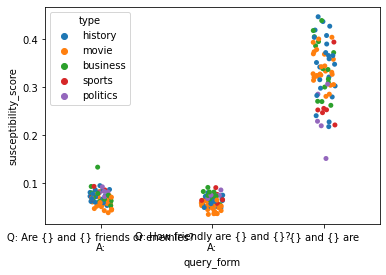

In [20]:
sns.stripplot(
    data=val_df_per_qe,
    x="query_form",
    y="susceptibility_score",
    hue="type",
    # hue="label",
    # dodge=True
    # jitter=0.1,
    # legend="full",
)

<AxesSubplot:xlabel='query_form', ylabel='susceptibility_score'>

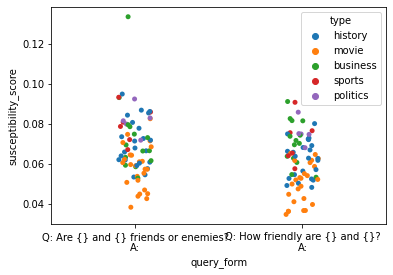

In [21]:
sns.stripplot(
    data=val_df_per_qe[val_df_per_qe["query_form"] != query_forms[-1]],
    x="query_form",
    y="susceptibility_score",
    hue="type",
    # hue="label",
    # dodge=True
    # jitter=0.1,
    # legend="full",
)

Error: You must call wandb.init() before wandb.log()

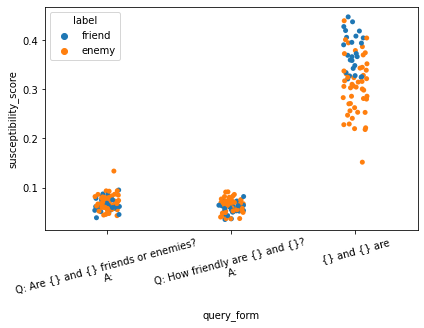

In [33]:
fig, ax = plt.subplots()
plot = sns.stripplot(
    data=val_df_per_qe,
    x="query_form",
    y="susceptibility_score",
    hue="label",
    ax=ax,
)
plt.tight_layout()
for tick in ax.get_xticklabels():
    tick.set_rotation(15)
plot_name = "plot_susscore_vs_queryform_friend_enemy"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path, bbox_inches="tight")
wandb.log({plot_name: wandb.Image(fig)})

Error: You must call wandb.init() before wandb.log()

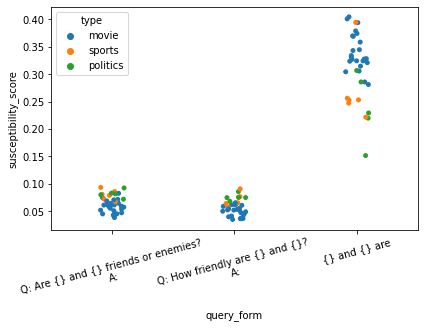

In [34]:
fig, ax = plt.subplots()
plot = sns.stripplot(
    data=val_df_per_qe[
        val_df_per_qe["type"].isin(
            [
                "sports",
                "politics",
                "movie",
            ]
        )
    ],
    x="query_form",
    y="susceptibility_score",
    hue="type",
    ax=ax,
    # hue="is_real",
    # dodge=True
    # jitter=0.1,
    # legend="full",
)
plt.tight_layout()
for tick in ax.get_xticklabels():
    tick.set_rotation(15)
plot_name = "plot_susscore_vs_queryform_type"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path, bbox_inches="tight")
wandb.log({plot_name: wandb.Image(fig)})

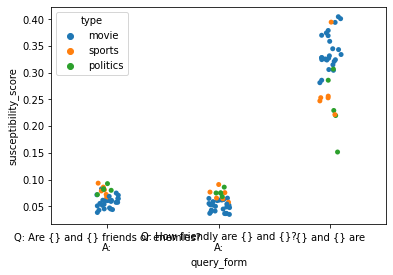

In [24]:
fig

In [25]:
wandb.finish()